<a href="https://colab.research.google.com/github/m1chae11u/Deep-CNN-2D-Floor-Plan-Classifier/blob/main/Deep_CNN_Image_Classifier_For_2D_Room_Layouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [12]:
import tensorflow as tf
import os

import zipfile
zip_path = '/content/data/ezyzip.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU') #shows all gpus available
#this is telling tensorflow to limit the memory consumption
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **Remove Bad Images**

In [14]:
import cv2
import imghdr

In [15]:
data_dir = '/content/data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list /content/data/2d-living-spaces/.DS_Store
Image not in ext list /content/data/2d-living-spaces/0f9927d4f1226162f619204b9a1d260bb2a2ba6a_2_666x500.gif
Image not in ext list /content/data/2d-living-spaces/4871-1stfloor.webp
Image not in ext list /content/data/2d-living-spaces/top-view-plan.gif
Image not in ext list /content/data/2d-living-spaces/a5df11186097009.Y3JvcCw1MDAwLDM5MTAsMCwyOTc.jpg
Image not in ext list /content/data/2d-living-spaces/s-l12002.webp
Image not in ext list /content/data/2d-living-spaces/518d6095b4e092bda51d35169c5f3b98.gif
Image not in ext list /content/data/2d-living-spaces/30253240223_d92127d7ef_z.jpg
Image not in ext list /content/data/2d-office-spaces/CHOPTANK-CONFERENCE-16.jpg
Image not in ext list /content/data/2d-office-spaces/.DS_Store
Image not in ext list /content/data/2d-office-spaces/8cff04e3ac2b4d0d8b0c3e154fd3fb77.webp


Load Data

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
#building data pipeline
data = tf.keras.utils.image_dataset_from_directory('/content/data')

Found 1079 files belonging to 2 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [20]:
batch = data_iterator.next()

In [21]:
batch[0].shape

(32, 256, 256, 3)

In [22]:
# Class 1 = 2D Office Spaces
# Class 0 = 2D Living Spaces
batch[1]

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0], dtype=int32)

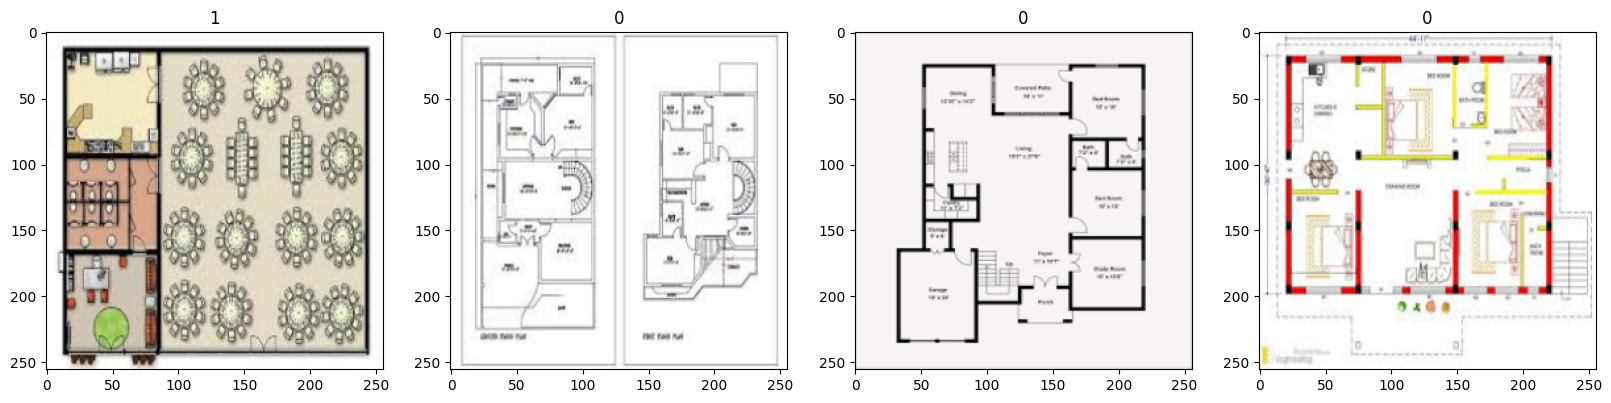

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index])

# **Preprocess Data**

In [24]:
#scaling the data
data = data.map(lambda x,y: ((x/255), y)) #scales all the pixel values to between 0 and 1, map function allows us to apply the scaling transformation as the data is accessed.

In [25]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

In [26]:
#splitting data into training, validation, and test partition
train_size = int(len(data)*.7) #used to train our model
val_size = int(len(data)*.2) + 1 #used to evaluate our model during training and fine tune
test_size = int(len(data)*.1) + 1 #used for post training evaluation
print(len(data) == (train_size + val_size + test_size))

True


In [27]:
#data is already shuffled
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
print(len(data) == len(train) + len(val) + len(test))

True


# **Building The Deep Learning Model**

In [28]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

In [29]:
# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

model = Sequential([
    data_augmentation,  # Data augmentation layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 256, 256, 3))  # Explicitly building the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)     

# **Training**

In [30]:
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

hist = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=[tensorboard_callback, reduce_lr]
)

Epoch 1/30
23/23 [==============================] - 72s 2s/step - loss: 1.0146 - accuracy: 0.7092 - val_loss: 2.1017 - val_accuracy: 0.4241 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 40s 2s/step - loss: 0.6055 - accuracy: 0.7378 - val_loss: 14.4478 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 40s 2s/step - loss: 0.5773 - accuracy: 0.7296 - val_loss: 10.5417 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7215
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
23/23 [==============================] - 40s 2s/step - loss: 0.6131 - accuracy: 0.7215 - val_loss: 4.6811 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 5/30
23/23 [==============================] - 40s 2s/step - loss: 0.5435 - accuracy: 0.7500 - val_loss: 6.2751 - val_accuracy: 0.4732 - lr: 2.0000e-04
Epoch 6/30
23/23 [==============================] - 40s 2s/step - los

# **Plot Performance**

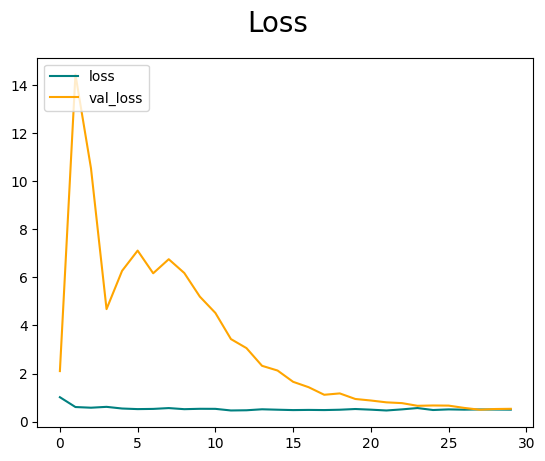

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

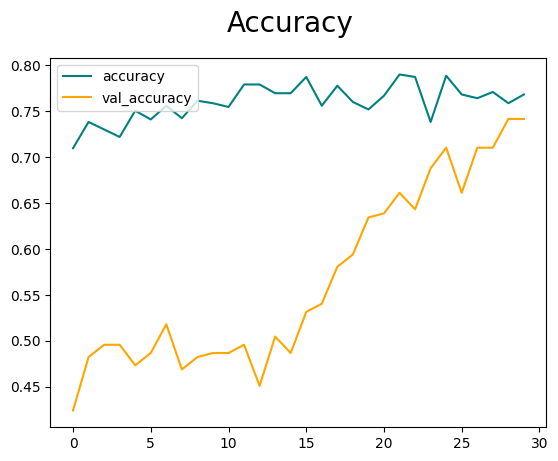

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Evaluate**

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
precs = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precs.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 34ms/step


In [38]:
print(f'Precision: {precs.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7027027010917664, Recall: 0.8524590134620667, Accuracy: 0.7394958138465881


# **Test**

In [46]:
imgliving1 = cv2.imread('/content/data/test/test-livingspace1.jpg')
imgliving2 = cv2.imread('/content/data/test/test-livingspace2.jpg')
imgoffice1 = cv2.imread('/content/data/test/test-office1.jpg')
imgoffice2 = cv2.imread('/content/data/test/test-office2.jpg')

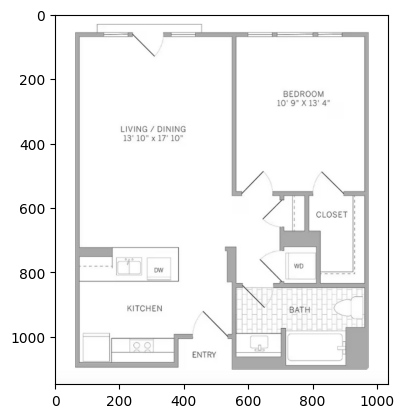

In [47]:
plt.imshow(imgliving1)
plt.show()

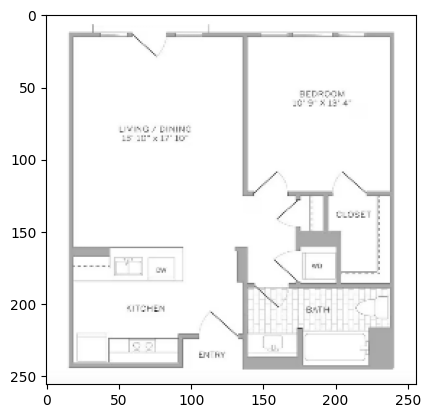

In [52]:
resize_imgliving1 = tf.image.resize(imgliving1, (256, 256))
resize_imgliving2 = tf.image.resize(imgliving2, (256, 256))
resize_imgoffice1 = tf.image.resize(imgoffice1, (256, 256))
resize_imgoffice2 = tf.image.resize(imgoffice2, (256, 256))

plt.imshow(resize_imgliving1.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize_imgliving1, 0)
np.expand_dims(resize_imgliving2, 0)
np.expand_dims(resize_imgoffice1, 0)
np.expand_dims(resize_imgoffice2, 0)

In [60]:
yhat_living1 = model.predict(np.expand_dims(resize_imgliving1/255, 0))
yhat_living2 = model.predict(np.expand_dims(resize_imgliving2/255, 0))
yhat_office1 = model.predict(np.expand_dims(resize_imgoffice1/255, 0))
yhat_office2 = model.predict(np.expand_dims(resize_imgoffice2/255, 0))
print("Living Space = 0")
print("Office Space = 1")
print(f'Living Space Test #1: {yhat_living1[0][0]}, Living Space Test #2: {yhat_living2[0][0]}/n Office Space Test #1: {yhat_office1[0][0]}/n Office Space Test #2: {yhat_office2[0][0]}/n')

1/1 [==============================] - 0s 19ms/step
Living Space = 0
Office Space = 1
Living Space Test #1: 0.7782304286956787, Living Space Test #2: 0.9981876015663147/n Office Space Test #1: 0.7831904292106628/n Office Space Test #2: 0.15791365504264832/n
